# Imports


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
workdir_path = '/content/gdrive/My Drive/domain-adaptation/code_updated'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Base Code

## Tools (file .py)

In [52]:
import os
import numpy as np
import scipy.io as sio
import skimage as sk
#from osgeo import gdal
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

def Analyse_hyperparameters_test(args, hyperparameters_file_path):
    f = open(hyperparameters_file_path, 'r')
    lines = f.readlines()
    for l in lines:
        fields = l.split(':')            
        if len(fields) > 1:
            field_1 = fields[0].split(' ')
            field_2 = fields[1].split(' ')
            field_head = str(field_1[-1])
            field_content = str((field_2[-1]))
            if field_head == '"epochs"':
                args.epochs = int(field_content[:-2])
            if field_head == '"lr"':
                args.lr = float(field_content[:-2])
            if field_head == '"beta1"':
                args.beta1 = float(field_content[:-2])
            if field_head == '"data_augmentation"':
                if field_content[:-2]=='true':
                    args.data_augmentation = True
                else:
                    args.data_augmentation = False
            if field_head == '"vertical_blocks"':
                args.vertical_blocks = int(field_content[:-2])
            if field_head == '"horizontal_blocks"':
                args.horizontal_blocks = int(field_content[:-2])
            if field_head == '"image_channels"':
                args.image_channels = int(field_content[:-2])
            if field_head == '"patches_dimension"':
                args.patches_dimension = int(field_content[:-2])
            if field_head == '"stride"':
                args.stride = int(field_content[:-2])          
            if field_head == '"compute_ndvi"':
                if field_content[:-2]=='true':
                    args.compute_ndvi = True
                else:
                    args.compute_ndvi = False
            if field_head == '"balanced_tr"':
                if field_content[:-2]=='true':
                    args.balanced_tr = True
                else:
                    args.balanced_tr = False
            if field_head == '"balanced_vl"':
                if field_content[:-2]=='true':
                    args.balanced_vl = True
                else:
                    args.balanced_vl = False
            if field_head == '"buffer"':
                if field_content[:-2]=='true':
                    args.buffer = True
                else:
                    args.buffer = False
            if field_head == '"porcent_of_last_reference_in_actual_reference"':
                args.porcent_of_last_reference_in_actual_reference = int(field_content[:-2])
            if field_head == '"patience"':
                args.patience = int(field_content[:-2])
            if field_head == '"data_t1_year"':
                args.data_t1_year = str(field_content[1:-3])
            if field_head == '"data_t2_year"':
                args.data_t2_year = str(field_content[1:-3])
            if field_head == '"data_t1_name"':
                args.data_t1_name = str(field_content[1:-3])
            if field_head == '"data_t2_name"':
                args.data_t2_name = str(field_content[1:-3])
            if field_head == '"reference_t1_name"':
                args.reference_t1_name = str(field_content[1:-3])
            if field_head == '"reference_t2_name"':
                args.reference_t2_name = str(field_content[1:-3])
            if field_head == '"data_type"':
                args.data_type = str(field_content[1:-3])
            if field_head =='"buffer_dimension_out"':
                args.buffer_dimension_out = int(field_content[:-2])
            if field_head =='"buffer_dimension_in"':
                args.buffer_dimension_in = int(field_content[:-2])
    return args

def save_as_mat(data, name):
    sio.savemat(name, {name: data})

def Read_TIFF_Image(Path):
    img =[]
    #gdal_header = gdal.Open(Path)
    #img = gdal_header.ReadAsArray()
    return img

def Compute_NDVI_Band(Image):
    Image = Image.astype(np.float32)
    nir_band = Image[4, :, :]
    red_band = Image[3, :, :]
    ndvi = np.zeros((Image.shape[1] , Image.shape[2] , 1))
    ndvi[ : , : , 0] = np.divide((nir_band-red_band),(nir_band+red_band))
    return ndvi

def compute_metrics(true_labels, predicted_labels):
    accuracy = 100*accuracy_score(true_labels, predicted_labels)
    f1score = 100*f1_score(true_labels, predicted_labels)
    recall = 100*recall_score(true_labels, predicted_labels)
    prescision = 100*precision_score(true_labels, predicted_labels)
    conf_mat = confusion_matrix(true_labels, predicted_labels)
    return accuracy, f1score, recall, prescision, conf_mat

def Data_Augmentation_Definition(corners_coordinates):
    num_sample = np.size(corners_coordinates , 0)
    data_cols = np.size(corners_coordinates , 1)    
    
    corners_coordinates_augmented = np.zeros((3 * num_sample, data_cols + 1))
    
    counter = 0
    for s in range(num_sample):
        corners_coordinates_0 = corners_coordinates[s]
        # central_pixels_coor_augmented[counter, 0 : 2] = central_pixels_coor_x_0
        # central_pixels_coor_augmented[counter, 2] = 0
        # labels_augmented[counter, :] = labels_y_0
        # counter += 1
        
        corners_coordinates_augmented[counter, 0 : 4] = corners_coordinates_0
        corners_coordinates_augmented[counter, 4] = 1
        counter += 1
        
        corners_coordinates_augmented[counter, 0 : 4] = corners_coordinates_0
        corners_coordinates_augmented[counter, 4] = 2
        counter += 1
        
        corners_coordinates_augmented[counter, 0 : 4] = corners_coordinates_0
        corners_coordinates_augmented[counter, 4] = 3
        counter += 1
        
    return corners_coordinates_augmented

def Data_Augmentation_Execution(data, transformation_indexs):
    num_sample = np.size(data , 0)
    data_rows = np.size(data , 1)
    data_cols = np.size(data , 2)
    data_depth = np.size(data , 3)
    data_transformed = np.zeros((num_sample, data_rows, data_cols, data_depth))
    print('dataset size After Data Augmentation:',data.shape)
    counter = 0
    for s in range(num_sample):
        data_x_0 = data[s, :, :, :]
        transformation_index = transformation_indexs[s]
        #Rotating
        if transformation_index == 0:
            data_transformed[s, :, :, :] = data_x_0
        if transformation_index == 1:
            data_transformed[s, :, :, :] = np.rot90(data_x_0)
        if transformation_index == 2:
            data_transformed[s, :, :, :] = np.flip(data_x_0, 0)
        if transformation_index == 3:
            data_transformed[s, :, :, :] = np.flip(data_x_0, 1)        
    return data_transformed   

def Patch_Extraction(data, corners_coordinates, domain_index, patch_size):

    data_rows = np.size(data[0], 0)
    data_cols = np.size(data[0], 1)
    data_depth = np.size(data[0], 2)
    num_samp = np.size(corners_coordinates , 0)
    
    patches_cointainer = np.zeros((num_samp, patch_size, patch_size, data_depth)) 
        
    data_padded = data
    for i in range(num_samp):
        data_padded_ = data_padded[int(domain_index[i,0])]
        patches_cointainer[i, :, :, :] = data_padded_[int(corners_coordinates[i , 0]) : int(corners_coordinates[i , 2]) , int(corners_coordinates[i , 1]) : int(corners_coordinates[i , 3]) , :]
    print('Number of total patches extracted:',num_samp)
    return patches_cointainer
    
def mask_creation(mask_row, mask_col, num_patch_row, num_patch_col, Train_tiles, Valid_tiles, Undesired_tiles):
    train_index = 1
    teste_index = 2
    valid_index = 3
    undesired_index = 4
    
    patch_dim_row = mask_row//num_patch_row
    patch_dim_col = mask_col//num_patch_col
    
    mask_array = 2 * np.ones((mask_row, mask_col))
    
    train_mask = np.ones((patch_dim_row, patch_dim_col))
    valid_mask = 3 * np.ones((patch_dim_row, patch_dim_col))
    undesired_mask = 4 * np.ones((patch_dim_row, patch_dim_col))
    counter_r = 1
    counter = 1
    for i in range(0, mask_row, patch_dim_row): 
        for j in range(0 , mask_col, patch_dim_col):           
            train = np.size(np.where(Train_tiles == counter),1)
            valid = np.size(np.where(Valid_tiles == counter),1)
            undesired = np.size(np.where(Undesired_tiles == counter), 1)
            if train == 1:
                mask_array[i : i + patch_dim_row, j : j + patch_dim_col] = train_mask
                if counter_r == num_patch_row:
                    mask_array[i : mask_row, j : j + patch_dim_col] = np.ones((mask_row - i, patch_dim_col))
            if valid == 1:
                mask_array[i : i + patch_dim_row, j : j + patch_dim_col] = valid_mask
                if counter_r == num_patch_row:
                    mask_array[i : mask_row, j : j + patch_dim_col] = 3 * np.ones((mask_row - i, patch_dim_col))
            if undesired == 1:
                mask_array[i : i + patch_dim_row, j : j + patch_dim_col] = undesired_mask
                if counter_r == num_patch_row:
                    mask_array[i : mask_row, j : j + patch_dim_col] = 4 * np.ones((mask_row - i, patch_dim_col))
            
            counter += 1       
        counter_r += 1
    return mask_array

def Corner_Coordinates_Definition_Training(mask, last_reference, actual_reference, patch_dimension, overlap_porcent, porcent_of_last_reference_in_actual_reference, porcent_of_positive_pixels_in_actual_reference):
    
    mask_rows = np.size(mask, 0)
    mask_cols = np.size(mask, 1)
    # Correcting the references for convenience
    last_reference[actual_reference == 2] = 1
    actual_reference[actual_reference == 2] = 0
    
    # Computing the overlaps and other things to extract patches
    overlap = round(patch_dimension * overlap_porcent)
    overlap -= overlap % 2
    stride = patch_dimension - overlap
    step_row = (stride - mask_rows % stride) % stride
    step_col = (stride - mask_cols % stride) % stride
    
    k1, k2 = (mask_rows + step_row)//stride, (mask_cols + step_col)//stride
    
    #Taking the initial coordinates
    coordinates = np.zeros((k1 * k2 , 4))
    counter = 0
    for i in range(k1):
        for j in range(k2):
            coordinates[counter, 0] = i * stride
            coordinates[counter, 1] = j * stride
            coordinates[counter, 2] = i * stride + patch_dimension
            coordinates[counter, 3] = j * stride + patch_dimension
            counter += 1
    print('-------------------------------')
    print('Total patches for image:',coordinates.shape)
    print('-------------------------------')
    pad_tuple = ((overlap//2, overlap//2 + step_row) , (overlap//2, overlap//2 + step_col))
    # Making the padding procedure 
    # into the mask
    mask_padded = np.pad(mask, pad_tuple, mode='symmetric')
    # into the past deforestation reference
    last_reference_padded = np.pad(last_reference, pad_tuple, mode='symmetric')
    # into the actual deforestation reference
    actual_reference_padded = np.pad(actual_reference, pad_tuple, mode='symmetric')    
    #Initializing the central pixels coordinates containers
    corners_coordinates_tr = []
    corners_coordinates_vl = []
    class_weights = []
    
    pad_tuple = ((overlap//2, overlap//2 + step_row) , (overlap//2, overlap//2 + step_col), (0 , 0))
    # Refine the central pixels coordinates
    counter_tr = 0
    counter_vl = 0
    positive_porcent_accumulated = 0
    for i in range(np.size(coordinates , 0)):
        mask_reference_value = mask_padded[int(coordinates[i , 0]) : int(coordinates[i , 2]) , int(coordinates[i , 1]) : int(coordinates[i , 3])]
        last_reference_value = last_reference_padded[int(coordinates[i , 0]) : int(coordinates[i , 2]) , int(coordinates[i , 1]) : int(coordinates[i , 3])]
        actual_reference_value = actual_reference_padded[int(coordinates[i , 0]) : int(coordinates[i , 2]) , int(coordinates[i , 1]) : int(coordinates[i , 3])]
        # Looking for a test pixels in the mask reference
        test_pixels_indexs = np.transpose(np.array(np.where(mask_reference_value == 2)))
        if np.size(test_pixels_indexs,0) == 0:
            number_positives_actual_reference = np.sum(actual_reference_value)
            porcent_of_positive_pixels_in_actual_reference_i = (number_positives_actual_reference/(patch_dimension * patch_dimension)) * 100
            if porcent_of_positive_pixels_in_actual_reference_i > porcent_of_positive_pixels_in_actual_reference:
                positive_porcent_accumulated += porcent_of_positive_pixels_in_actual_reference_i
                train_pixels_indexs = np.transpose(np.array(np.where(mask_reference_value == 1)))
                valid_pixels_indexs = np.transpose(np.array(np.where(mask_reference_value == 3)))
                porcent_of_training_pixels = (train_pixels_indexs.shape[0]/(patch_dimension * patch_dimension)) * 100
                porcent_of_validation_pixels = (valid_pixels_indexs.shape[0]/(patch_dimension * patch_dimension)) * 100
                if porcent_of_training_pixels > 70:
                    corners_coordinates_tr.append(coordinates[i , :])
                if porcent_of_validation_pixels > 70:
                    corners_coordinates_vl.append(coordinates[i , :])
                counter_tr += 1            
    
    mean_positive_porcent = positive_porcent_accumulated/counter_tr
    class_weights.append(mean_positive_porcent/100)
    class_weights.append(1 - (mean_positive_porcent/100))
    print('Total patches for training:',len(corners_coordinates_tr))
    print('Total patches for validation:',len(corners_coordinates_vl))
    return corners_coordinates_tr, corners_coordinates_vl, last_reference_padded, actual_reference_padded, pad_tuple, class_weights

def Corner_Coordinates_Definition_Testing(mask, patch_dimension, overlap_porcent):
    
    mask_rows = np.size(mask, 0)
    mask_cols = np.size(mask, 1)
    
    # Computing the overlaps and other things to extract patches
    overlap = round(patch_dimension * overlap_porcent)
    overlap -= overlap % 2
    stride = patch_dimension - overlap
    step_row = (stride - mask_rows % stride) % stride
    step_col = (stride - mask_cols % stride) % stride
    
    k1, k2 = (mask_rows + step_row)//stride, (mask_cols + step_col)//stride
    
    #Taking the initial coordinates
    coordinates = np.zeros((k1 * k2 , 4))
    counter = 0
    for i in range(k1):
        for j in range(k2):
            coordinates[counter, 0] = i * stride
            coordinates[counter, 1] = j * stride
            coordinates[counter, 2] = i * stride + patch_dimension
            coordinates[counter, 3] = j * stride + patch_dimension
            counter += 1
    
    pad_tuple = ((overlap//2, overlap//2 + step_row) , (overlap//2, overlap//2 + step_col), (0 , 0))
    
    return coordinates, pad_tuple, k1, k2, step_row, step_col, stride, overlap

def Classification_Maps(Predicted_labels, True_labels, central_pixels_coordinates, hit_map):
        
    Classification_Map = np.zeros((hit_map.shape[0], hit_map.shape[1], 3))
    TP_counter = 0
    FP_counter = 0
    for i in range(central_pixels_coordinates.shape[0]):
        
        T_label = True_labels[i]
        P_label = Predicted_labels[i]
        
        if T_label == 1:
            if P_label == T_label:
                TP_counter += 1
                #True positve
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),0] = 0
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),1] = 255
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),2] = 0
            else:
                #False Negative
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),0] = 255
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),1] = 255
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),2] = 0
        if T_label == 0:
            if P_label == T_label:
                #True Negative
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),0] = 255
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),1] = 255
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),2] = 255
            else:
                #False Positive
                FP_counter += 1
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),0] = 255
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),1] = 0
                Classification_Map[int(central_pixels_coordinates[i , 0]),int(central_pixels_coordinates[i , 1]),2] = 0

    return Classification_Map, TP_counter, FP_counter 
        
def plot_embedding(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        # plot colored number
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.bwr(d[i] / 1.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)       

## Amazonia_RO + Cerrado_MA

In [53]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology
from skimage.morphology import square, disk 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# from Tools import *

class AMAZON_RO():
    def __init__(self, args):
        
        self.images_norm = []
        self.references = []
        self.mask = []
        self.coordinates = []
         
        Image_t1_path = args.dataset_main_path + args.dataset + args.images_section + args.data_t1_name + '.npy'
        Image_t2_path = args.dataset_main_path + args.dataset + args.images_section + args.data_t2_name + '.npy'
        Reference_t1_path = args.dataset_main_path + args.dataset + args.reference_section + args.reference_t1_name + '.npy'
        Reference_t2_path = args.dataset_main_path + args.dataset + args.reference_section + args.reference_t2_name + '.npy'
        # print(Image_t1_path)
        # Reading images and references
        print('[*]Reading images...')
        image_t1 = np.load(Image_t1_path)
        image_t2 = np.load(Image_t2_path)
        reference_t1 = np.load(Reference_t1_path)
        self.image_t1 = image_t1
        self.image_t2 = image_t2
        image_t1 = image_t1[:,1:2551,1:5121]
        image_t2 = image_t2[:,1:2551,1:5121]
        print(np.min(image_t1))
        print(np.max(image_t1))
        
        reference_t1 = reference_t1[1:2551,1:5121]
        if os.path.exists(Reference_t2_path):
            reference_t2 = np.load(Reference_t2_path)
            if reference_t2.shape[0] != reference_t1.shape[0] and reference_t2.shape[1] != reference_t1.shape[1]: 
                reference_t2 = reference_t2[1:2551,1:5121]
        elif args.reference_t2_name == 'None':
            reference_t2 = np.ones((2550, 5120))
        elif args.reference_t2_name == 'NDVI':
            ndvi_t1 = Compute_NDVI_Band(image_t1) 
            ndvi_t2 = Compute_NDVI_Band(image_t2)
            reference_t2_1 = np.zeros_like(ndvi_t1)
            reference_t2_2 = np.zeros_like(ndvi_t2)
            reference_t2_1[ndvi_t1 > 0.27] = 0
            reference_t2_1[ndvi_t1 <= 0.27] = 1
            reference_t2_2[ndvi_t2 > 0.27] = 0
            reference_t2_2[ndvi_t2 <= 0.27] = 1
            reference_t2 = reference_t2_2 - reference_t2_1
            reference_t2[reference_t2 == -1] = 0
            reference_t2 = reference_t2[:,:,0]
            #plt.imshow(reference_t2[:,:,0])
            #plt.show()  
            #sys.exit()
        # Pre-processing references
        if args.buffer:
            print('[*]Computing buffer regions...')
            #Dilating the reference_t1
            reference_t1 = skimage.morphology.dilation(reference_t1, disk(args.buffer_dimension_out))
            if os.path.exists(Reference_t2_path) or args.reference_t2_name == 'NDVI':
                #Dilating the reference_t2
                reference_t2_dilated = skimage.morphology.dilation(reference_t2, disk(args.buffer_dimension_out))
                buffer_t2_from_dilation = reference_t2_dilated - reference_t2
                reference_t2_eroded  = skimage.morphology.erosion(reference_t2 , disk(args.buffer_dimension_in))
                buffer_t2_from_erosion  = reference_t2 - reference_t2_eroded
                buffer_t2 = buffer_t2_from_dilation + buffer_t2_from_erosion
                reference_t2 = reference_t2 - buffer_t2_from_erosion
                buffer_t2[buffer_t2 == 1] = 2
                reference_t2 = reference_t2 + buffer_t2
                
        # Pre-processing images
        if args.compute_ndvi:
            print('[*]Computing and stacking the ndvi band...')
            ndvi_t1 = Compute_NDVI_Band(image_t1)
            ndvi_t2 = Compute_NDVI_Band(image_t2)
            image_t1 = np.transpose(image_t1, (1, 2, 0))
            image_t2 = np.transpose(image_t2, (1, 2, 0))
            image_t1 = np.concatenate((image_t1, ndvi_t1), axis=2)
            image_t2 = np.concatenate((image_t2, ndvi_t2), axis=2)
        else:
            image_t1 = np.transpose(image_t1, (1, 2, 0))
            image_t2 = np.transpose(image_t2, (1, 2, 0))
        
        
        # Pre-Processing the images
       
        print('[*]Normalizing the images...')
        scaler = StandardScaler()
        #scaler = MinMaxScaler()
        images = np.concatenate((image_t1, image_t2), axis=2)
        images_reshaped = images.reshape((images.shape[0] * images.shape[1], images.shape[2]))
        
        scaler = scaler.fit(images_reshaped)
        self.scaler = scaler
        images_normalized = scaler.fit_transform(images_reshaped)
        images_norm = images_normalized.reshape((images.shape[0], images.shape[1], images.shape[2]))
        image_t1_norm = images_norm[:, :, : image_t1.shape[2]]
        image_t2_norm = images_norm[:, :, image_t2.shape[2]: ]
        print('Shape actual reference t1:',image_t1_norm.shape)
        print('Shape past reference t2:',image_t2_norm.shape)
        # print(np.min(image_t1_norm))
        # print(np.max(image_t1_norm))
        # print(np.min(image_t2_norm))
        # print(np.max(image_t2_norm))
        
        # Storing the images in a list
        self.images_norm.append(image_t1_norm)
        self.images_norm.append(image_t2_norm)
        # Storing the references in a list
        self.references.append(reference_t1)
        self.references.append(reference_t2)
    
    def Tiles_Configuration(self, args, i):
        #Generating random training and validation tiles
        if args.phase == 'train' or args.phase == 'compute_metrics':
            if args.fixed_tiles:
                if args.defined_before:
                    if args.phase == 'train':
                        files = os.listdir(args.checkpoint_dir_posterior)
                        print(files[i])
                        self.Train_tiles = np.load(args.checkpoint_dir_posterior + '/' + files[i] + '/' + 'Train_tiles.npy')
                        self.Valid_tiles = np.load(args.checkpoint_dir_posterior + '/' + files[i] + '/' + 'Valid_tiles.npy')
                        np.save(args.save_checkpoint_path + 'Train_tiles' , self.Train_tiles)
                        np.save(args.save_checkpoint_path + 'Valid_tiles' , self.Valid_tiles)
                    if args.phase == 'compute_metrics':
                        self.Train_tiles = np.load(args.save_checkpoint_path +  'Train_tiles.npy')
                        self.Valid_tiles = np.load(args.save_checkpoint_path +  'Valid_tiles.npy')
                else:
                    # self.Train_tiles = np.array([1, 5, 17, 22, 28, 43, 55, 64, 88, 97])
                    # self.Train_tiles = np.array([5, 17, 28, 43, 64, 88])
                    # self.Valid_tiles = np.array([3, 11, 49, 78])
                    self.Train_tiles = custom_tiles_amazon_train #np.array([2, 6, 13, 24, 28, 35, 37, 46, 47, 53, 58, 60, 64, 71, 75, 82, 86, 88, 93])
                    self.Valid_tiles = custom_tiles_amazon_validation #np.array([8, 11, 26, 49, 78])
                    self.Undesired_tiles = []
            else:
                tiles = np.random.randint(100, size = 25) + 1
                self.Train_tiles = tiles[:20]
                self.Valid_tiles = tiles[20:]
                np.save(args.save_checkpoint_path + 'Train_tiles' , self.Train_tiles)
                np.save(args.save_checkpoint_path + 'Valid_tiles' , self.Valid_tiles)
        if args.phase == 'test':
            self.Train_tiles = []
            self.Valid_tiles = []
            self.Undesired_tiles = []
            
    def Coordinates_Creator(self, args, i):
        self.images_norm_ = []
        self.references_ = []
        print('[*]Defining the central patches coordinates...')
        if args.phase == 'train':
            if args.fixed_tiles:
                if i == 0:
                    self.mask = mask_creation(self.images_norm[0].shape[0], self.images_norm[0].shape[1], args.horizontal_blocks, args.vertical_blocks, self.Train_tiles, self.Valid_tiles, self.Undesired_tiles)
                
                self.corners_coordinates_tr, self.corners_coordinates_vl, reference1_, reference2_, self.pad_tuple, self.class_weights = Corner_Coordinates_Definition_Training(self.mask, self.references[0], self.references[1], args.patches_dimension, args.overlap, args.porcent_of_last_reference_in_actual_reference, args.porcent_of_positive_pixels_in_actual_reference)
                sio.savemat(args.save_checkpoint_path + 'mask.mat', {'mask': self.mask})
            else:
                self.mask = mask_creation(self.images_norm[0].shape[0], self.images_norm[0].shape[1], args.horizontal_blocks, args.vertical_blocks, self.Train_tiles, self.Valid_tiles, self.Undesired_tiles)
                sio.savemat(args.save_checkpoint_path + 'mask.mat', {'mask': self.mask})
                self.corners_coordinates_tr, self.corners_coordinates_vl, reference1_, reference2_, self.pad_tuple, self.class_weights = Corner_Coordinates_Definition_Training(self.mask, self.references[0], self.references[1], args.patches_dimension, args.overlap, args.porcent_of_last_reference_in_actual_reference, args.porcent_of_positive_pixels_in_actual_reference)
            
            self.references_.append(reference1_)
            self.references_.append(reference2_)    
        if args.phase == 'test':
            self.mask = mask_creation(self.images_norm[0].shape[0], self.images_norm[0].shape[1], args.horizontal_blocks, args.vertical_blocks, self.Train_tiles, self.Valid_tiles, self.Undesired_tiles)
            self.corners_coordinates_ts, self.pad_tuple, self.k1, self.k2, self.step_row, self.step_col, self.stride, self.overlap = Corner_Coordinates_Definition_Testing(self.mask, args.patches_dimension, args.overlap)
            
        # Performing the corresponding padding into the images
        self.images_norm_.append(np.pad(self.images_norm[0], self.pad_tuple, mode='symmetric'))
        self.images_norm_.append(np.pad(self.images_norm[1], self.pad_tuple, mode='symmetric'))
        
        print(np.shape(self.images_norm))
 

In [54]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology
from skimage.morphology import square, disk 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# from Tools import *

class CERRADO_MA():
    def __init__(self, args):
        
        self.images_norm = []
        self.references = []
        self.mask = []
        self.coordinates = []
         
        Image_t1_path = args.dataset_main_path + args.dataset + args.images_section + args.data_t1_name + '.npy'
        Image_t2_path = args.dataset_main_path + args.dataset + args.images_section + args.data_t2_name + '.npy'
        Reference_t1_path = args.dataset_main_path + args.dataset + args.reference_section + args.reference_t1_name + '.npy'
        Reference_t2_path = args.dataset_main_path + args.dataset + args.reference_section + args.reference_t2_name + '.npy'
        
        # Reading images and references
        print('[*]Reading images...')
        image_t1 = np.load(Image_t1_path)
        image_t2 = np.load(Image_t2_path)
        self.image_t1 = image_t1
        self.image_t2 = image_t2
        reference_t1 = np.load(Reference_t1_path)
        image_t1 = image_t1[:,:1700,:1440]
        image_t2 = image_t2[:,:1700,:1440]
        reference_t1 = reference_t1[:1700,:1440]
        if os.path.exists(Reference_t2_path):
            reference_t2 = np.load(Reference_t2_path)
            if reference_t2.shape[0] != reference_t1.shape[0] and reference_t2.shape[1] != reference_t1.shape[1]: 
                reference_t2 = reference_t2[:1700,:1440]
        elif args.reference_t2_name == 'None':
            reference_t2 = np.ones((1700, 1440))
        elif args.reference_t2_name == 'NDVI': 
            ndvi_t1 = Compute_NDVI_Band(image_t1) 
            ndvi_t2 = Compute_NDVI_Band(image_t2)
            reference_t2_1 = np.zeros_like(ndvi_t1)
            reference_t2_2 = np.zeros_like(ndvi_t2)
            reference_t2_1[ndvi_t1 > 0.25] = 0
            reference_t2_1[ndvi_t1 <= 0.25] = 1
            reference_t2_2[ndvi_t2 > 0.25] = 0
            reference_t2_2[ndvi_t2 <= 0.25] = 1
            reference_t2 = reference_t2_2 - reference_t2_1
            reference_t2[reference_t2 == -1] = 0
            reference_t2 = reference_t2[:,:,0]
            # plt.imshow(reference_t2[:,:,0])
            # plt.show()  
            # sys.exit()
        
        # Pre-processing references
        if args.buffer:
            print('[*]Computing buffer regions...')
            #Dilating the reference_t1
            reference_t1 = skimage.morphology.dilation(reference_t1, disk(args.buffer_dimension_out))
            if os.path.exists(Reference_t2_path) or args.reference_t2_name == 'NDVI':
                #Dilating the reference_t2
                reference_t2_dilated = skimage.morphology.dilation(reference_t2, disk(args.buffer_dimension_out))
                buffer_t2_from_dilation = reference_t2_dilated - reference_t2
                reference_t2_eroded  = skimage.morphology.erosion(reference_t2 , disk(args.buffer_dimension_in))
                buffer_t2_from_erosion  = reference_t2 - reference_t2_eroded
                buffer_t2 = buffer_t2_from_dilation + buffer_t2_from_erosion
                reference_t2 = reference_t2 - buffer_t2_from_erosion
                buffer_t2[buffer_t2 == 1] = 2
                reference_t2 = reference_t2 + buffer_t2
                
        # Pre-processing images
        if args.compute_ndvi:
            print('[*]Computing and stacking the ndvi band...')
            ndvi_t1 = Compute_NDVI_Band(image_t1)
            ndvi_t2 = Compute_NDVI_Band(image_t2)
            image_t1 = np.transpose(image_t1, (1, 2, 0))
            image_t2 = np.transpose(image_t2, (1, 2, 0))
            image_t1 = np.concatenate((image_t1, ndvi_t1), axis=2)
            image_t2 = np.concatenate((image_t2, ndvi_t2), axis=2)
        else:
            image_t1 = np.transpose(image_t1, (1, 2, 0))
            image_t2 = np.transpose(image_t2, (1, 2, 0))
        
        
        # Pre-Processing the images
        
        print('[*]Normalizing the images...')
        scaler = StandardScaler()
        #scaler = MinMaxScaler()
        images = np.concatenate((image_t1, image_t2), axis=2)
        images_reshaped = images.reshape((images.shape[0] * images.shape[1], images.shape[2]))
        
        scaler = scaler.fit(images_reshaped)
        self.scaler = scaler
        images_normalized = scaler.fit_transform(images_reshaped)
        images_norm = images_normalized.reshape((images.shape[0], images.shape[1], images.shape[2]))
        image_t1_norm = images_norm[:, :, : image_t1.shape[2]]
        image_t2_norm = images_norm[:, :, image_t2.shape[2]: ]
        print('Shape actual reference t1:',image_t1_norm.shape)
        print('Shape actual reference t2:',image_t2_norm.shape)
        # print(np.min(image_t1_norm))
        # print(np.max(image_t1_norm))
        # print(np.min(image_t2_norm))
        # print(np.max(image_t2_norm))
        
        # Storing the images in a list
        self.images_norm.append(image_t1_norm)
        self.images_norm.append(image_t2_norm)
        # Storing the references in a list
        self.references.append(reference_t1)
        self.references.append(reference_t2)
        
          
    def Tiles_Configuration(self, args, i):
        #Generating random training and validation tiles
        if args.phase == 'train' or args.phase == 'compute_metrics':
            if args.fixed_tiles:
                if args.defined_before:
                    if args.phase == 'train':
                        files = os.listdir(args.checkpoint_dir_posterior)
                        print(files[i])
                        self.Train_tiles = np.load(args.checkpoint_dir_posterior + '/' + files[i] + '/' + 'Train_tiles.npy')
                        self.Valid_tiles = np.load(args.checkpoint_dir_posterior + '/' + files[i] + '/' + 'Valid_tiles.npy')
                        np.save(args.save_checkpoint_path + 'Train_tiles' , self.Train_tiles)
                        np.save(args.save_checkpoint_path + 'Valid_tiles' , self.Valid_tiles)
                    if args.phase == 'compute_metrics':
                        self.Train_tiles = np.load(args.save_checkpoint_path +  'Train_tiles.npy')
                        self.Valid_tiles = np.load(args.save_checkpoint_path +  'Valid_tiles.npy')
                else:
                    self.Train_tiles = np.array([2, 5, 9, 13, 15])
                    self.Valid_tiles = np.array([6, 7])
                    self.Undesired_tiles = []
            else:
                #This nedd to be redefined
                tiles = np.random.randint(100, size = 25) + 1
                self.Train_tiles = tiles[:20]
                self.Valid_tiles = tiles[20:]
                np.save(args.save_checkpoint_path + 'Train_tiles' , self.Train_tiles)
                np.save(args.save_checkpoint_path + 'Valid_tiles' , self.Valid_tiles)
        if args.phase == 'test':
            self.Train_tiles = []
            self.Valid_tiles = []
            self.Undesired_tiles = []
            
    def Coordinates_Creator(self, args, i):
        self.images_norm_ = []
        self.references_ = []
        print('[*]Defining the central patches coordinates...')
        if args.phase == 'train':
            if args.fixed_tiles:
                if i == 0:
                    self.mask = mask_creation(self.images_norm[0].shape[0], self.images_norm[0].shape[1], args.horizontal_blocks, args.vertical_blocks, self.Train_tiles, self.Valid_tiles, self.Undesired_tiles)
                
                self.corners_coordinates_tr, self.corners_coordinates_vl, reference1_, reference2_, self.pad_tuple, self.class_weights = Corner_Coordinates_Definition_Training(self.mask, self.references[0], self.references[1], args.patches_dimension, args.overlap, args.porcent_of_last_reference_in_actual_reference, args.porcent_of_positive_pixels_in_actual_reference)
                sio.savemat(args.save_checkpoint_path + 'mask.mat', {'mask': self.mask})
            else:
                self.mask = mask_creation(self.images_norm[0].shape[0], self.images_norm[0].shape[1], args.horizontal_blocks, args.vertical_blocks, self.Train_tiles, self.Valid_tiles, self.Undesired_tiles)
                sio.savemat(args.save_checkpoint_path + 'mask.mat', {'mask': self.mask})
                self.corners_coordinates_tr, self.corners_coordinates_vl, reference1_, reference2_, self.pad_tuple, self.class_weights = Corner_Coordinates_Definition_Training(self.mask, self.references[0], self.references[1], args.patches_dimension, args.overlap, args.porcent_of_last_reference_in_actual_reference, args.porcent_of_positive_pixels_in_actual_reference)
            
            self.references_.append(reference1_)
            self.references_.append(reference2_)    
        if args.phase == 'test':
            self.mask = mask_creation(self.images_norm[0].shape[0], self.images_norm[0].shape[1], args.horizontal_blocks, args.vertical_blocks, self.Train_tiles, self.Valid_tiles, self.Undesired_tiles)
            self.corners_coordinates_ts, self.pad_tuple, self.k1, self.k2, self.step_row, self.step_col, self.stride, self.overlap = Corner_Coordinates_Definition_Testing(self.mask, args.patches_dimension, args.overlap)
            
        # Performing the corresponding padding into the images
        self.images_norm_.append(np.pad(self.images_norm[0], self.pad_tuple, mode='symmetric'))
        self.images_norm_.append(np.pad(self.images_norm[1], self.pad_tuple, mode='symmetric'))
        
        print(np.shape(self.images_norm))

## Models (file .py)

In [55]:
import os
import sys
import time
import skimage
import numpy as np
import scipy.io as sio
from tqdm import trange
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from contextlib import redirect_stdout

class DataModels():
    def __init__(self, args, dataset):
        self.args = args
        self.dataset_s = dataset[0]
        self.dataset_t = dataset[1]

    def data_preparation(self):
        
        best_f1score = 0
        pat = 0
        #TODO Lucas: Perguntar ao Pedro se esse class_weights está correto 
        class_weights = []
        class_weights.append(0.4)
        class_weights.append(2)
        
        reference_t1_s = np.zeros((self.dataset_s.references_[0].shape[0], self.dataset_s.references_[0].shape[1], 1))
        reference_t2_s = np.zeros((self.dataset_s.references_[0].shape[0], self.dataset_s.references_[0].shape[1], 1))
        reference_t1_t = np.zeros((self.dataset_t.references_[0].shape[0], self.dataset_t.references_[0].shape[1], 1))
        reference_t2_t = np.zeros((self.dataset_t.references_[0].shape[0], self.dataset_t.references_[0].shape[1], 1))
        if self.args.balanced_tr:
            class_weights = self.dataset_s.class_weights
        
        # Copy the original input values    
        corners_coordinates_tr_s = self.dataset_s.corners_coordinates_tr.copy()
        corners_coordinates_vl_s = self.dataset_s.corners_coordinates_vl.copy()
        reference_t1_ = self.dataset_s.references_[0].copy()
        reference_t1_[self.dataset_s.references_[0] == 0] = 1
        reference_t1_[self.dataset_s.references_[0] == 1] = 0
       
        reference_t1_s[:,:,0] = reference_t1_.copy()
        reference_t2_s[:,:,0] = self.dataset_s.references_[1].copy()
        
        if self.args.training_type == 'domain_adaptation':
            corners_coordinates_tr_t = self.dataset_t.corners_coordinates_tr.copy()
            corners_coordinates_vl_t = self.dataset_t.corners_coordinates_vl.copy()
        
        print('Sets dimensions before data augmentation')
        print('Source dimensions: ')
        print(np.shape(corners_coordinates_tr_s))
        print(np.shape(corners_coordinates_vl_s))
        if self.args.training_type == 'domain_adaptation':
            print('Target dimension: ')
            print(np.shape(corners_coordinates_tr_t))
            print(np.shape(corners_coordinates_vl_t))
            
        if self.args.data_augmentation:
            corners_coordinates_tr_s = Data_Augmentation_Definition(corners_coordinates_tr_s)
            corners_coordinates_vl_s = Data_Augmentation_Definition(corners_coordinates_vl_s)
            if self.args.training_type == 'domain_adaptation':
                corners_coordinates_tr_t = Data_Augmentation_Definition(corners_coordinates_tr_t)
                corners_coordinates_vl_t = Data_Augmentation_Definition(corners_coordinates_vl_t)                
        
        print('Sets dimensions before balancing')
        print('Source dimensions: ')
        print(np.shape(corners_coordinates_tr_s))
        print(np.shape(corners_coordinates_vl_s))
        if self.args.training_type == 'domain_adaptation':
            print('Target dimension: ')
            print(np.shape(corners_coordinates_tr_t))
            print(np.shape(corners_coordinates_vl_t))
        
            # Balancing the number of samples between source and target domain
            size_tr_s = corners_coordinates_tr_s.shape[0]
            size_tr_t = corners_coordinates_tr_t.shape[0]
            size_vl_s = corners_coordinates_vl_s.shape[0]
            size_vl_t = corners_coordinates_vl_t.shape[0]
                        
            if size_tr_s < size_tr_t:
                diff = size_tr_t - size_tr_s 
                corners_coordinates_tr_s = np.concatenate((corners_coordinates_tr_s , corners_coordinates_tr_s[:diff,:]),axis=0)
            if size_tr_t < size_tr_s:
                diff = size_tr_s - size_tr_t
                corners_coordinates_tr_t = np.concatenate((corners_coordinates_tr_t , corners_coordinates_tr_t[:diff,:]),axis=0)
                
            if size_vl_s < size_vl_t:
                diff = size_vl_t - size_vl_s 
                corners_coordinates_vl_s = np.concatenate((corners_coordinates_vl_s , corners_coordinates_vl_s[:diff,:]),axis=0)
            if size_vl_t < size_vl_s:
                diff = size_vl_s - size_vl_t
                corners_coordinates_vl_t = np.concatenate((corners_coordinates_vl_t , corners_coordinates_vl_t[:diff,:]),axis=0)
            
            print('Sets dimensions after balancing')
            print('Source dimensions: ')
            print(np.shape(corners_coordinates_tr_s))
            print(np.shape(corners_coordinates_vl_s))
            self.corners_coordinates_tr_s = corners_coordinates_tr_s
            self.corners_coordinates_vl_s = corners_coordinates_vl_s
            
        # if self.args.training_type == 'domain_adaptation':
            print('Target dimension: ')
            print(np.shape(corners_coordinates_tr_t))
            print(np.shape(corners_coordinates_vl_t))
            self.corners_coordinates_tr_t = corners_coordinates_tr_t
            self.corners_coordinates_vl_t = corners_coordinates_vl_t

        print(np.shape(reference_t1_s))
        print(np.shape(reference_t2_s))
                    
        data = []
        x_train = np.concatenate((self.dataset_s.images_norm_[0], self.dataset_s.images_norm_[1], reference_t1_s, reference_t2_s), axis = 2)
        data.append(x_train)
        self.x_train = x_train
        if self.args.training_type == 'domain_adaptation':
            x_train_t = np.concatenate((self.dataset_t.images_norm_[0], self.dataset_t.images_norm_[1], reference_t1_t, reference_t2_t), axis = 2)
            data.append(x_train_t)
            self.x_train_t = x_train_t
        # Training configuration
        if self.args.training_type == 'classification':
            # Domain indexs configuration
            corners_coordinates_tr = corners_coordinates_tr_s.copy()
            corners_coordinates_vl = corners_coordinates_vl_s.copy()
            
            domain_indexs_tr = np.zeros((corners_coordinates_tr.shape[0], 1))
            domain_indexs_vl = np.zeros((corners_coordinates_vl.shape[0], 1))    
            
        if self.args.training_type == 'domain_adaptation':
            # Concatenating coordinates from source and target domains
            corners_coordinates_tr = np.concatenate((corners_coordinates_tr_s, corners_coordinates_tr_t), axis = 0)
            corners_coordinates_vl = np.concatenate((corners_coordinates_vl_s, corners_coordinates_vl_t), axis = 0)
            # Domain indexs configuration
            domain_indexs_tr_s = np.zeros((corners_coordinates_tr_s.shape[0], 1))
            domain_indexs_tr_t = np.ones((corners_coordinates_tr_t.shape[0], 1))
            domain_indexs_vl_s = np.zeros((corners_coordinates_vl_s.shape[0], 1))
            domain_indexs_vl_t = np.ones((corners_coordinates_vl_t.shape[0], 1))
            
            domain_indexs_tr = np.concatenate((domain_indexs_tr_s, domain_indexs_tr_t), axis = 0)
            domain_indexs_vl = np.concatenate((domain_indexs_vl_s, domain_indexs_vl_t), axis = 0)
            # Domain labels configuration
            #source_labels_tr = np.ones((corners_coordinates_tr_s.shape[0], self.args.patches_dimension, self.args.patches_dimension))
            #target_labels_tr = np.zeros((corners_coordinates_tr_t.shape[0], self.args.patches_dimension, self.args.patches_dimension))
            source_labels_tr = np.ones((corners_coordinates_tr_s.shape[0], 1))
            target_labels_tr = np.zeros((corners_coordinates_tr_t.shape[0], 1))
            #source_labels_vl = np.ones((corners_coordinates_vl_s.shape[0], self.args.patches_dimension, self.args.patches_dimension))
            #target_labels_vl = np.zeros((corners_coordinates_vl_t.shape[0], self.args.patches_dimension, self.args.patches_dimension))
            source_labels_vl = np.ones((corners_coordinates_vl_s.shape[0], 1))
            target_labels_vl = np.zeros((corners_coordinates_vl_t.shape[0], 1))
            
            y_train_d = np.concatenate((source_labels_tr, target_labels_tr), axis = 0)
            y_valid_d = np.concatenate((source_labels_vl, target_labels_vl), axis = 0)
            self.y_train_d = y_train_d
            self.y_valid_d = y_valid_d
        self.corners_coordinates_tr = corners_coordinates_tr
        self.corners_coordinates_vl = corners_coordinates_vl
        #Computing the number of batches
        self.num_batches_tr = corners_coordinates_tr.shape[0]//self.args.batch_size
        self.num_batches_vl = corners_coordinates_vl.shape[0]//self.args.batch_size
        # batch_counter_cl = 0
        # batchs = trange(num_batches_tr)
        
        for b in [0]:
            corners_coordinates_tr_batch = corners_coordinates_tr[b * self.args.batch_size : (b + 1) * self.args.batch_size , :]
            domain_index_batch = domain_indexs_tr[b * self.args.batch_size : (b + 1) * self.args.batch_size, :]
            #print(domain_index_batch)
            if self.args.data_augmentation:
                transformation_indexs_batch = corners_coordinates_tr[b * self.args.batch_size : (b + 1) * self.args.batch_size , 4]

            #Extracting the data patches from it's coordinates
            data_batch_ = Patch_Extraction(data, corners_coordinates_tr_batch, domain_index_batch, self.args.patches_dimension)
            # print(np.shape(data_batch_))
            if self.args.data_augmentation:
                data_batch_ = Data_Augmentation_Execution(data_batch_, transformation_indexs_batch)
            # Recovering data
            self.data_batch = data_batch_[:,:,:,: 2 * self.args.image_channels]
            # Recovering past reference
            self.reference_t1_ = data_batch_[:,:,:, 2 * self.args.image_channels]
            self.reference_t2_ = data_batch_[:,:,:, 2 * self.args.image_channels + 1]
        # plt.imshow(reference_t1_[0,:,:])
        # plt.show()
        # plt.imshow(reference_t2_[0,:,:])
        # plt.show()
        # Hot encoding the reference_t2_

In [56]:
import os
import sys
import json
import argparse
import numpy as np
import tensorflow as tf
import skimage.morphology
from datetime import datetime
import matplotlib.pyplot as plt
from skimage.morphology import square, disk 
from sklearn.preprocessing import StandardScaler

def loader(args = None):
    if not os.path.exists('./checkpoints/'):
        os.makedirs('./checkpoints/')
    args.checkpoint_dir = './checkpoints/' + args.checkpoint_dir 
    args.buffer_dimension_in = args.source_buffer_dimension_in
    args.buffer_dimension_out = args.source_buffer_dimension_out
    args.data_t1_name = args.source_data_t1_name
    args.data_t2_name = args.source_data_t2_name
    args.reference_t1_name = args.source_reference_t1_name
    args.reference_t2_name = args.source_reference_t2_name
    if args.source_dataset == 'Amazon_RO':
        args.dataset = 'Amazonia_Legal/'
        dataset_s = AMAZON_RO(args)
        
    elif args.source_dataset == 'Amazon_PA':
        args.dataset = 'Amazonia_Legal/'
        dataset_s = AMAZON_PA(args)
        
    elif args.source_dataset == 'Cerrado_MA':
        args.dataset = 'Cerrado_Biome/'
        dataset_s = CERRADO_MA(args)
                            
    args.buffer_dimension_in = args.target_buffer_dimension_in
    args.buffer_dimension_out = args.target_buffer_dimension_out
    args.data_t1_name = args.target_data_t1_name
    args.data_t2_name = args.target_data_t2_name
    args.reference_t1_name = args.target_reference_t1_name
    args.reference_t2_name = args.target_reference_t2_name if args.target_reference_t2_name is not None else 'None'
    if args.target_dataset == 'Amazon_RO':
        args.dataset = 'Amazonia_Legal/'
        dataset_t = AMAZON_RO(args)
        
    elif args.target_dataset == 'Amazon_PA':
        args.dataset = 'Amazonia_Legal/'
        dataset_t = AMAZON_PA(args)
        
    elif args.target_dataset == 'Cerrado_MA':
        args.dataset = 'Cerrado_Biome/'
        dataset_t = CERRADO_MA(args)
        
    # print(np.shape(dataset_s.images_norm))
    # print(np.shape(dataset_t.images_norm))
    for i in range(1):
        dataset = []
        # print(i)
        now = datetime.now()
        dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
        # print(dt_string)
        if args.training_type == 'classification':
            args.save_checkpoint_path = args.checkpoint_dir + '/' + args.method_type + '_' + dt_string + '/'
        if args.training_type == 'domain_adaptation' or args.training_type == 'domain_adaptation_balance':
            args.save_checkpoint_path = args.checkpoint_dir + '/' + 'Tr_M_' + dt_string + '/'
        if not os.path.exists(args.save_checkpoint_path):
            os.makedirs(args.save_checkpoint_path)
            #Writing the args into a file
        with open(args.save_checkpoint_path + 'commandline_args.txt', 'w') as f:
            json.dump(args.__dict__, f, indent=2)
        
        args.vertical_blocks = args.source_vertical_blocks
        args.horizontal_blocks = args.source_horizontal_blocks
        args.overlap = args.overlap_s
        args.porcent_of_positive_pixels_in_actual_reference = args.porcent_of_positive_pixels_in_actual_reference_s
        dataset_s.Tiles_Configuration(args, i)
        dataset_s.Coordinates_Creator(args, i)
        
        args.vertical_blocks = args.target_vertical_blocks
        args.horizontal_blocks = args.target_horizontal_blocks
        args.overlap = args.overlap_t
        args.porcent_of_positive_pixels_in_actual_reference = args.porcent_of_positive_pixels_in_actual_reference_t
        dataset_t.Tiles_Configuration(args, i)
        dataset_t.Coordinates_Creator(args, i)
        
        dataset.append(dataset_s)
        dataset.append(dataset_t) 
        
        print('[*]Initializing the model...')
        model = DataModels(args, dataset)
        model.data_preparation()
    return model

# Inspect Data

In [57]:
def parse_params(params):
  parser = argparse.ArgumentParser(description='parse key pairs into a dictionary')

  for key,value in params.items():
    parser.add_argument("--"+key, dest=key,type = type(value),default=value)

  parser.add_argument("-f", "--file", required=False)
  args = parser.parse_args()
  return args

workdir_path = '/content/gdrive/My Drive/domain-adaptation'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

In [58]:
overlap = 0.75
epochs = 50
batch_size = 32
learning_rate = 0.0001
training_type = 'classification'
runs = 1
patches_dimension = 128

aspp_rates = [3,6,12]
backbone_net = 'resnet_v2_34'
resnet_filters = (16,32,64)
resnet_stages = (2,2,2)
resnet_residual_block_type = 'simple'
resnet_low_level_node = '/block1/unit2/add_shortcut'
resnet_endpoint = '/block3/unit2/add_shortcut'

da_beta = 5
loss_type = ''
loss_gamma = 2
loss_alpha = 0.1
bn_decay = 0.9
porcent_positives = 2

train_dir_amazon = '20201216_01_classification_Train_Amazon'
train_dir_cerrado = '20201216_01_classification_Train_Cerrado'

train_dir_da_amazon_to_cerrado = '20201216_01_DA_Source_Amazon_Target_Cerrado'
train_dir_da_cerrado_to_amazon = '20201216_01_DA_Source_Cerrado_Target_Amazon'

train_params_amazon = {
    'method_type':'DeepLab',
    'batch_norm_decay': bn_decay,
    'is_training':True,
    'base_architecture':backbone_net,
    'aspp_rates':aspp_rates,
    'resnet_stages':resnet_stages,
    'resnet_residual_block_type':resnet_residual_block_type,
    'resnet_low_level_node':resnet_low_level_node,
    'resnet_endpoint':resnet_endpoint,
    'resnet_filters':resnet_filters,

    'epochs':epochs,
    'batch_size': batch_size, 
    'lr': learning_rate,
    'beta1':0.9,
    'num_classes': 2,
    'patience': 10,
    'da_beta':da_beta,
    'balanced_tr':True,
    'save_intermediate_model':False,
    'loss_type':loss_type,
    'loss_gamma':loss_gamma,
    'loss_alpha':loss_alpha,

    'phase':'train',
    'training_type':training_type,
    'runs':runs,
    'overlap_s':overlap,
    'overlap_t':overlap,

    'data_augmentation':True,
    'source_vertical_blocks':10,
    'source_horizontal_blocks':10,
    'target_vertical_blocks':3,
    'target_horizontal_blocks':5,
    'image_channels':7,
    'patches_dimension':patches_dimension,

    'compute_ndvi':False,
    'defined_before':False,
    'fixed_tiles':True,

    'buffer':True,
    'source_buffer_dimension_out':4,
    'source_buffer_dimension_in':2,
    'target_buffer_dimension_out':2,
    'target_buffer_dimension_in':0,

    'porcent_of_positive_pixels_in_actual_reference_s':porcent_positives,
    'porcent_of_positive_pixels_in_actual_reference_t':porcent_positives,
    'porcent_of_last_reference_in_actual_reference':100,

    'source_dataset': 'Amazon_RO',
    'target_dataset': 'Cerrado_MA',

    'source_data_t1_year':'2016',
    'source_data_t2_year':'2017',
    'target_data_t1_year':'2017',
    'target_data_t2_year':'2018',

    'source_data_t1_name':'18_07_2016_image_R232_67_RO',
    'source_data_t2_name':'21_07_2017_image_R232_67_RO',
    'target_data_t1_name':'18_08_2017_image_R220_63_MA',
    'target_data_t2_name':'21_08_2018_image_R220_63_MA',

    'source_reference_t1_name':'PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO',
    'source_reference_t2_name':'REFERENCE_2017_EPSG32620_R232_67_RO',
    'target_reference_t1_name':'PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA',
    'target_reference_t2_name':'None',

    'images_section': 'Organized/Images/',
    'reference_section': 'Organized/References/',
    'data_type': '.npy',
    'dataset_main_path':'Datasets/',
    'checkpoint_dir':train_dir_amazon,
}

train_params_cerrado = {
    'method_type':'DeepLab',
    'batch_norm_decay': bn_decay,
    'is_training':True,
    'base_architecture':backbone_net,
    'aspp_rates':aspp_rates,
    'resnet_stages':resnet_stages,
    'resnet_residual_block_type':resnet_residual_block_type,
    'resnet_low_level_node':resnet_low_level_node,
    'resnet_endpoint':resnet_endpoint,
    'resnet_filters':resnet_filters,

    'epochs':epochs,
    'batch_size': batch_size, 
    'lr': learning_rate,
    'beta1':0.9,
    'num_classes': 2,
    'patience': 10,
    'balanced_tr':True,
    'save_intermediate_model':False,
    'da_beta':da_beta,
    'loss_type':loss_type,
    'loss_gamma':loss_gamma,
    'loss_alpha':loss_alpha,

    'phase':'train',
    'training_type':training_type,
    'runs':runs,
    'overlap_s':overlap,
    'overlap_t':overlap,

    'data_augmentation':True,
    'source_vertical_blocks':3,
    'source_horizontal_blocks':5,
    'target_vertical_blocks':10,
    'target_horizontal_blocks':10,
    'image_channels':7,
    'patches_dimension':patches_dimension,

    'compute_ndvi':False,
    'defined_before':False,
    'fixed_tiles':True,

    'buffer':True,
    'source_buffer_dimension_out':2,
    'source_buffer_dimension_in':0,
    'target_buffer_dimension_out':2,
    'target_buffer_dimension_in':0,

    'porcent_of_positive_pixels_in_actual_reference_s':porcent_positives,
    'porcent_of_positive_pixels_in_actual_reference_t':porcent_positives,
    'porcent_of_last_reference_in_actual_reference':100,

    'source_dataset': 'Cerrado_MA',
    'target_dataset': 'Amazon_RO',

    'source_data_t1_year':'2017',
    'source_data_t2_year':'2018',
    'target_data_t1_year':'2016',
    'target_data_t2_year':'2017',

    'source_data_t1_name':'18_08_2017_image_R220_63_MA',
    'source_data_t2_name':'21_08_2018_image_R220_63_MA',
    'target_data_t1_name':'18_07_2016_image_R232_67_RO',
    'target_data_t2_name':'21_07_2017_image_R232_67_RO',

    'source_reference_t1_name':'PAST_REFERENCE_FOR_2018_EPSG4674_R220_63_MA',
    'source_reference_t2_name':'REFERENCE_2018_EPSG4674_R220_63_MA',
    'target_reference_t1_name':'PAST_REFERENCE_FOR_2017_EPSG32620_R232_67_RO',
    'target_reference_t2_name':'None',

    'images_section': 'Organized/Images/',
    'reference_section': 'Organized/References/',
    'data_type': '.npy',
    'dataset_main_path':'Datasets/',
    'checkpoint_dir':train_dir_cerrado,
}

In [59]:
custom_tiles_amazon_train = np.array([2, 6, 13, 24, 28, 35, 37, 46, 47, 53, 58, 60, 64, 71, 75, 82, 86, 88, 93])
custom_tiles_amazon_validation = np.array([8, 11, 26, 49, 78])

In [60]:
data_models = loader(args = parse_params(train_params_amazon))

[*]Reading images...
4203.0
65535.0
[*]Computing buffer regions...
[*]Normalizing the images...
Shape actual reference t1: (2550, 5120, 7)
Shape past reference t2: (2550, 5120, 7)
[*]Reading images...
[*]Computing buffer regions...
[*]Normalizing the images...
Shape actual reference t1: (1700, 1440, 7)
Shape actual reference t2: (1700, 1440, 7)
[*]Defining the central patches coordinates...
-------------------------------
Total patches for image: (12800, 4)
-------------------------------
Total patches for training: 180
Total patches for validation: 55
(2, 2550, 5120, 7)
[*]Defining the central patches coordinates...
-------------------------------
Total patches for image: (2430, 4)
-------------------------------
Total patches for training: 579
Total patches for validation: 188
(2, 1700, 1440, 7)
[*]Initializing the model...
Sets dimensions before data augmentation
Source dimensions: 
(180, 4)
(55, 4)
Sets dimensions before balancing
Source dimensions: 
(540, 5)
(165, 5)
(2656, 5216, 

In [43]:
data_models.dataset_s.image_t1.shape

(7, 2554, 5130)

In [67]:
np.size(data_models.dataset_s.corners_coordinates_tr)

720

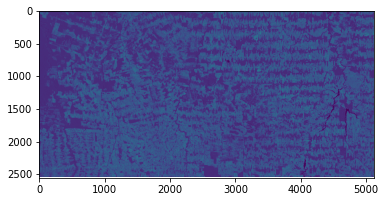

In [64]:
plt.imshow(data_models.dataset_s.image_t1[5,:,:])

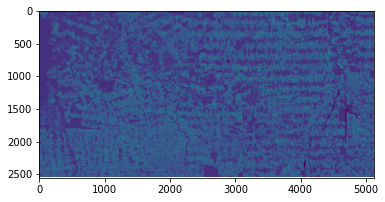

In [65]:
plt.imshow(data_models.dataset_s.image_t2[5,:,:])

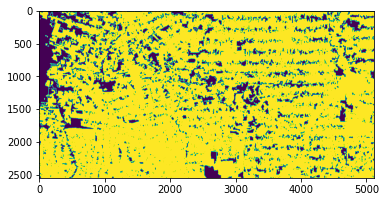

In [50]:
plt.imshow(data_models.dataset_s.references[0])

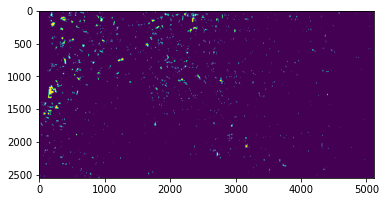

In [51]:
plt.imshow(data_models.dataset_s.references[1])

In [46]:
data_models_cerrado = loader(args = parse_params(train_params_cerrado))

[*]Reading images...
[*]Computing buffer regions...
[*]Normalizing the images...
Shape actual reference t1: (1700, 1440, 7)
Shape actual reference t2: (1700, 1440, 7)
[*]Reading images...
4203.0
65535.0
[*]Computing buffer regions...
[*]Normalizing the images...
Shape actual reference t1: (2550, 5120, 7)
Shape past reference t2: (2550, 5120, 7)
[*]Defining the central patches coordinates...
(2, 1700, 1440, 7)
[*]Defining the central patches coordinates...
(2, 2550, 5120, 7)
[*]Initializing the model...
Sets dimensions before data augmentation
Source dimensions: 
(108, 4)
(58, 4)
Sets dimensions before balancing
Source dimensions: 
(324, 5)
(174, 5)
(1824, 1536, 1)
(1824, 1536, 1)
Number of total patches extracted: 32
dataset size After Data Augmentation: (32, 128, 128, 16)


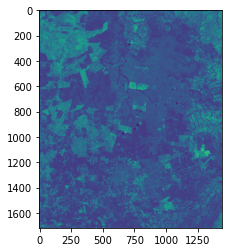

In [62]:
# plt.imshow(np.sum(data_models_cerrado.dataset_s.image_t1,0))
plt.imshow(data_models_cerrado.dataset_s.image_t1[5,:,:])

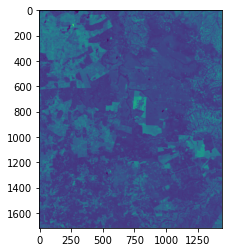

In [63]:
# plt.imshow(np.sum(data_models_cerrado.dataset_s.image_t2,0))
plt.imshow(data_models_cerrado.dataset_s.image_t2[5,:,:])

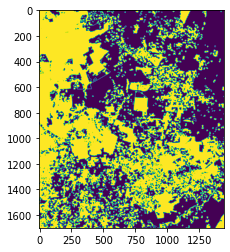

In [53]:
plt.imshow(data_models_cerrado.dataset_s.references[0])

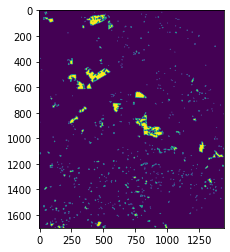

In [52]:
plt.imshow(data_models_cerrado.dataset_s.references[1])

In [21]:
train_params_amazon['training_type'] = 'domain_adaptation'
data_models_amazon_source_da = loader(args = parse_params(train_params_amazon))

[*]Reading images...
4203.0
65535.0
[*]Computing buffer regions...
[*]Normalizing the images...
Shape actual reference t1: (2550, 5120, 7)
Shape past reference t2: (2550, 5120, 7)
[*]Reading images...
[*]Computing buffer regions...
[*]Normalizing the images...
Shape actual reference t1: (1700, 1440, 7)
Shape actual reference t2: (1700, 1440, 7)
[*]Defining the central patches coordinates...
(2, 2550, 5120, 7)
[*]Defining the central patches coordinates...
(2, 1700, 1440, 7)
[*]Initializing the model...
Sets dimensions before data augmentation
Source dimensions: 
(180, 4)
(55, 4)
Target dimension: 
(579, 4)
(188, 4)
Sets dimensions before balancing
Source dimensions: 
(540, 5)
(165, 5)
Target dimension: 
(1737, 5)
(564, 5)
Sets dimensions after balancing
Source dimensions: 
(1080, 5)
(330, 5)
Target dimension: 
(1737, 5)
(564, 5)
(2656, 5216, 1)
(2656, 5216, 1)
Number of total patches extracted: 32
dataset size After Data Augmentation: (32, 128, 128, 16)


In [22]:
train_params_cerrado['training_type'] = 'domain_adaptation'
data_models_cerrado_source_da = loader(args = parse_params(train_params_cerrado))

[*]Reading images...
[*]Computing buffer regions...
[*]Normalizing the images...
Shape actual reference t1: (1700, 1440, 7)
Shape actual reference t2: (1700, 1440, 7)
[*]Reading images...
4203.0
65535.0
[*]Computing buffer regions...
[*]Normalizing the images...
Shape actual reference t1: (2550, 5120, 7)
Shape past reference t2: (2550, 5120, 7)
[*]Defining the central patches coordinates...
(2, 1700, 1440, 7)
[*]Defining the central patches coordinates...
(2, 2550, 5120, 7)
[*]Initializing the model...
Sets dimensions before data augmentation
Source dimensions: 
(108, 4)
(58, 4)
Target dimension: 
(1076, 4)
(284, 4)
Sets dimensions before balancing
Source dimensions: 
(324, 5)
(174, 5)
Target dimension: 
(3228, 5)
(852, 5)
Sets dimensions after balancing
Source dimensions: 
(648, 5)
(348, 5)
Target dimension: 
(3228, 5)
(852, 5)
(1824, 1536, 1)
(1824, 1536, 1)
Number of total patches extracted: 32
dataset size After Data Augmentation: (32, 128, 128, 16)
